In [91]:
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/analysis/derivatives/')

import importlib
import alchemical_derivatives as ad
importlib.reload(ad)
import glob
import numpy as np

from matplotlib import pyplot as plt
import scipy.interpolate as si

import os

In [92]:
xyz_path = f'/data/sahre/projects/atomic_force_field/bond_stretch/butanol/dist_0.0/ve_32/GEOMETRY.xyz'
atom_symbols, nuc_charges, positions, valence_charges = ad.parse_xyz_for_CPMD_input(xyz_path)

In [137]:
derivative_labels = atom_symbols['elIdx'].copy()

In [35]:
ad.get_energy_contributions([f'{compound_dir}/{ve}/dE_d{atom}_{pos}/run.log'])

Logfile at /data/sahre/projects/atomic_force_field/bond_stretch/butanol/dist_0.0/ve_06/dE_dC2_fw/run.log does not exist


({'TOTAL ENERGY =': array([], dtype=float64),
  'KINETIC ENERGY =': array([], dtype=float64),
  'ELECTROSTATIC ENERGY =': array([], dtype=float64),
  '(E+I)-(E+I) HARTREE ENERGY =': array([], dtype=float64),
  '(PSEUDO CHARGE I-I) ENERGY =': array([], dtype=float64),
  '(E-E) HARTREE ENERGY =': array([], dtype=float64),
  'ESELF =': array([], dtype=float64),
  'ESR =': array([], dtype=float64),
  'LOCAL PSEUDOPOTENTIAL ENERGY =': array([], dtype=float64),
  'N-L PSEUDOPOTENTIAL ENERGY =': array([], dtype=float64),
  'EXCHANGE-CORRELATION ENERGY =': array([], dtype=float64),
  'GRADIENT CORRECTION ENERGY =': array([], dtype=float64)},
 array([], dtype=float64),
 array([], dtype=float64))

In [154]:
compound_dir = '/data/sahre/projects/atomic_force_field/bond_stretch/butanol/dist_0.0'
ves = ['ve_13', 've_19' , 've_26',  've_32']
derivatives = {k: [] for k in derivative_labels}
dlam = 2e-5
for ve in ves:
    for atom in derivative_labels:
        eois = []
        for pos in ['bw', 'fw']:
            
            if not os.path.isfile(f'{compound_dir}/{ve}/dE_d{atom}_{pos}/run.log'):
                print(f'{compound_dir}/{ve}/dE_d{atom}_{pos}/run.log')
            
            energy_contributions, e_el_cpmd, nuc_rep_cpmd = ad.get_energy_contributions([f'{compound_dir}/{ve}/dE_d{atom}_{pos}/run.log'])
            # eoi = energy_contributions['N-L PSEUDOPOTENTIAL ENERGY ='][0]
            # eoi = energy_contributions['KINETIC ENERGY ='][0]
            # eoi = energy_contributions['TOTAL ENERGY ='][0]
            # eoi = energy_contributions['EXCHANGE-CORRELATION ENERGY ='][0]
            eoi = e_el_cpmd[0]
            eois.append(eoi)
        deri = (eois[1]-eois[0])/dlam
        derivatives[atom].append(deri)
# sorted_lam_vals, logfiles = sort_lambda_logfiles(logdirs)
# energy_contributions_H2, e_el_cpmd_H2, nuc_rep_cpmd_H2 = get_energy_contributions(logfiles_H2)
for k in derivatives.keys():
    derivatives[k].insert(0, 0.0)
    
energies_target = ad.get_energy_contributions([f'{compound_dir}/{ves[-1]}/run.log'])[0]
energies_ref = ad.get_energy_contributions([f'{compound_dir}/ve_00/run.log'])[0]
e_tot_ref = -2.097729
energies_exact = dict()

for k in energies_target.keys():
    energies_exact[k] = energies_target[k] #- energies_ref[k]
energies_exact['ENUC'] = (energies_target['(PSEUDO CHARGE I-I) ENERGY =']+energies_target['ESR =']-energies_target['ESELF =']) - (energies_ref['(PSEUDO CHARGE I-I) ENERGY =']+energies_ref['ESR =']-energies_ref['ESELF ='])

In [146]:
lambda_values = np.array([0,13,19,26,32])/32

Text(29.25, 0.5, '$\\partial_{V_I} E$ (Ha)')

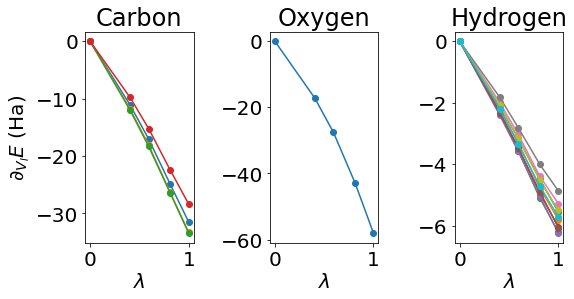

In [147]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,3)
fig.set_figwidth(8)
fig.tight_layout()
for k in derivatives.keys():
    if 'C' in k:
        ax[0].plot(lambda_values, derivatives[k], '-o')
    elif 'O' in k:
        ax[1].plot(lambda_values, derivatives[k], '-o')
    elif 'H' in k:
        ax[2].plot(lambda_values, derivatives[k], '-o')

title = ['Carbon', 'Oxygen', 'Hydrogen']
for i in range(3):
    ax[i].set_xlabel(r'$\lambda$')
    ax[i].set_title(title[i])
ax[0].set_ylabel(r'$\partial_{V_I} E$ (Ha)')

# plt.savefig('/home/sahre/projects/derivatives/figures/butanol_partial_derivatives.png', dpi = 300, bbox_inches = 'tight')

In [148]:
splines = dict()
integrals = []
for k in derivatives.keys():
    splines[k] = si.CubicSpline(lambda_values, derivatives[k])
    integrals.append(splines[k].integrate(0,1))
    # splines = spline

In [167]:
atomic_energies_data_old = np.loadtxt('/data/sahre/projects/atomic_force_field/bond_stretch/butanol/dist_0.0/atomic_energies_pp.txt')

In [168]:
error_el = np.array(integrals).sum() - (energies_exact['TOTAL ENERGY =']-e_tot_ref-energies_exact['ENUC'])
error_el_old = atomic_energies_data_old[:,-2].sum() - (energies_exact['TOTAL ENERGY =']-e_tot_ref-energies_exact['ENUC'])
print(f'Error electronic energy finite diff = {error_el[0]}')
print(f'Error electronic energy finite diff = {error_el_old[0]}')

Error electronic energy finite diff = -0.3661582092078106
Error electronic energy finite diff = -74.95730867797957


-186.51358719797958